In [75]:
# %matplotlib inline
%pylab inline
import scipy
from pyiga import bspline, assemble, vform, geometry, vis, solvers
import numpy as np
import matplotlib.pyplot as plt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\mechadmin\Documents\GitHub\pyiga\.venv\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


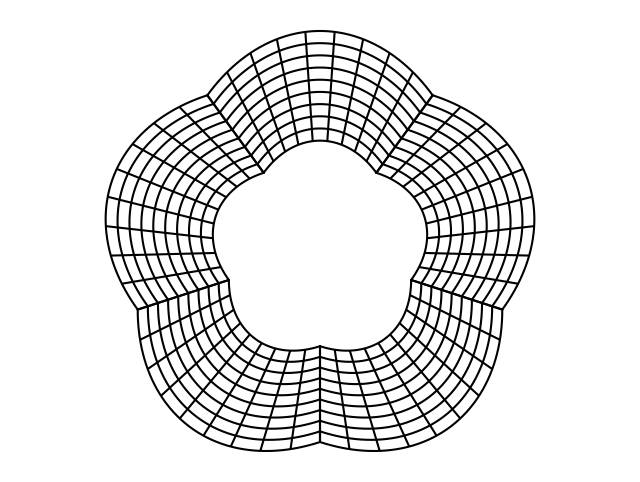

In [117]:
n = 2
f = geometry.circular_arc(pi/n)
g = geometry.line_segment([0.5,0.5], [1,1])
G = geometry.outer_product(f,g) # create pie slice
# vis.plot_geo(G)
G1 = G.rotate_2d(pi*0.25) # rotate pie slice to upright position
# vis.plot_geo(G1)

G2 = G1.scale([0.726,1]) # stretch pie slice in x & y-dir
# vis.plot_geo(G2)

geos = [
    G2,
    G2.rotate_2d(pi*.4),
    G2.rotate_2d(2*pi*.4),
    G2.rotate_2d(3*pi*.4),
    G2.rotate_2d(4*pi*.4),
]

for g in geos:
    vis.plot_geo(g)
    
axis('equal');
axis('off');

In [ ]:
n = 2
f = geometry.circular_arc(pi/n)
g1 = geometry.line_segment([0,0], [1,1])
G = geometry.outer_product(f,g1) # create pie slice
# vis.plot_geo(G)
G1 = G.rotate_2d(pi*0.25) # rotate pie slice to upright position
# vis.plot_geo(G1)

G2 = G1.scale([0.726,1]) # stretch pie slice in x & y-dir
# vis.plot_geo(G2)

geos = [
    G2,
    G2.rotate_2d(pi*.4),
    G2.rotate_2d(2*pi*.4),
    G2.rotate_2d(3*pi*.4),
    G2.rotate_2d(4*pi*.4),
]

for g1 in geos:
    vis.plot_geo(g1)
    
axis('equal');
axis('off');

In [116]:
# define discretization space (the same in each patch)
p = 3
kvs = 2 * (bspline.make_knots(p, 0.5, 1.0, 15),)

patches = [(kvs, g) for g in geos]

# Here we auto-detect the interfaces between the patches.
# It is also possible to join them manually using
# MP.join_boundaries(...) followed by MP.finalize().

MP = assemble.Multipatch(patches, automatch=True)

In [119]:
# define discretization space (the same in each patch)
p = 3
kvs = 2 * (bspline.make_knots(p, 0, 1.0, 15),)

patches = [(kvs, g1) for g1 in geos]

# Here we auto-detect the interfaces between the patches.
# It is also possible to join them manually using
# MP.join_boundaries(...) followed by MP.finalize().

MP = assemble.Multipatch(patches, automatch=True)

In [124]:
MP.patches

[((KnotVector(array([0.        , 0.        , 0.        , 0.        , 0.06666667,
          0.13333333, 0.2       , 0.26666667, 0.33333333, 0.4       ,
          0.46666667, 0.53333333, 0.6       , 0.66666667, 0.73333333,
          0.8       , 0.86666667, 0.93333333, 1.        , 1.        ,
          1.        , 1.        ]), 3),
   KnotVector(array([0.        , 0.        , 0.        , 0.        , 0.06666667,
          0.13333333, 0.2       , 0.26666667, 0.33333333, 0.4       ,
          0.46666667, 0.53333333, 0.6       , 0.66666667, 0.73333333,
          0.8       , 0.86666667, 0.93333333, 1.        , 1.        ,
          1.        , 1.        ]), 3)),
  <pyiga.geometry.NurbsFunc at 0x1ca42077d60>),
 ((KnotVector(array([0.        , 0.        , 0.        , 0.        , 0.06666667,
          0.13333333, 0.2       , 0.26666667, 0.33333333, 0.4       ,
          0.46666667, 0.53333333, 0.6       , 0.66666667, 0.73333333,
          0.8       , 0.86666667, 0.93333333, 1.        , 1.        

In [122]:
# source term f and Dirichlet boundary function g
f = lambda x, y: exp(-5 * ((x-0.3)**2 + (y-1)**2))
g1 = lambda x,y: 1e-1 * sin(8*x)

# set up Dirichlet boundary conditions
bcs = MP.compute_dirichlet_bcs([
    (0, 'bottom', g1), (0, 'right', g1),
    (1, 'top', g1),
    (2, 'left', g1), (2, 'bottom', g1),
    (3, 'bottom', 0),
])

# assemble the linear system
A, rhs = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [120]:
# source term f and Dirichlet boundary function g
f = lambda x, y: exp(-5 * ((x-0.3)**2 + (y-1)**2))
g = lambda x,y: 1e-1 * sin(8*x)

# set up Dirichlet boundary conditions
bcs = MP.compute_dirichlet_bcs([
    (0, 'bottom', g), (0, 'right', g),
    (1, 'top', g),
    (2, 'left', g), (2, 'bottom', g),
    (3, 'bottom', 0),
])

# assemble the linear system
A, rhs = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [109]:
# set up and solve linear system
LS = assemble.RestrictedLinearSystem(A, rhs, bcs)

u = LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b))

# restrict solution to each individual patch
u_funcs = [geometry.BSplineFunc(kvs, MP.global_to_patch(p) @ u)
           for p in range(len(patches))]

In [110]:
kvs

(KnotVector(array([0.5       , 0.5       , 0.5       , 0.5       , 0.53333333,
        0.56666667, 0.6       , 0.63333333, 0.66666667, 0.7       ,
        0.73333333, 0.76666667, 0.8       , 0.83333333, 0.86666667,
        0.9       , 0.93333333, 0.96666667, 1.        , 1.        ,
        1.        , 1.        ]), 3),
 KnotVector(array([0.5       , 0.5       , 0.5       , 0.5       , 0.53333333,
        0.56666667, 0.6       , 0.63333333, 0.66666667, 0.7       ,
        0.73333333, 0.76666667, 0.8       , 0.83333333, 0.86666667,
        0.9       , 0.93333333, 0.96666667, 1.        , 1.        ,
        1.        , 1.        ]), 3))

In [111]:
figsize(8,6)

for (u_func, (kvs, geo)) in zip(u_funcs, patches):
    vis.plot_field(u_func, geo, vmin=0, vmax=1.5e-1)
axis('scaled')
colorbar();

ValueError: negative column index found